In [2]:
import theano
from theano import *
import theano.tensor as T
%pylab inline
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import gzip
import pickle
import matplotlib as mpl
import warnings
warnings.simplefilter('ignore')
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 16

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/python3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gradient', 'dot', 'generic', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## AMPTH 207: Stochastic Methods for Data Analysis, Inference and Optimization

### Long Homework 1

**Harvard University**  
**Spring 2017**  
**Instructor: Rahul Dave**  
**Due Date:** Thursday, Febrary 23rd, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Premise

In supervised machine learning, a function that maps certain input data to a set of outputs is inferred from a labelled dataset called the training set, and the resulting learnt funtion is then used to make predictions on unseen new examples of the dataset (the test set).

The goal of this homework is to construct a classifier known as the single-hidden-layer Multi-Layer Perceptron (MLP), an artificial neural netwok. You are asked to train the classifier using mini-batch gradient descent, validate it, and then apply it to a test dataset to make predictions. We will use the [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database), which consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You can use the first 50,000 images as the training set, the next 10,000 images as the validation set, and the last 10,000 images as the test set.

You will proceed in 2 steps (each step is a problem) to build the MLP. Please use Theano to program the classifiers.

## Problem 1. Stochastic gradient descent for the logistic regresion

First, build a logistic regression classifier whose input is the array of pixel values in one image, and whose output is the most likely class of the vector. In order to familiarize yourself with the dataset, plot some of the images beforehand, and think about the pixel values as features of the input vector.

In [3]:
dataset='mnist.pkl.gz'
with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)

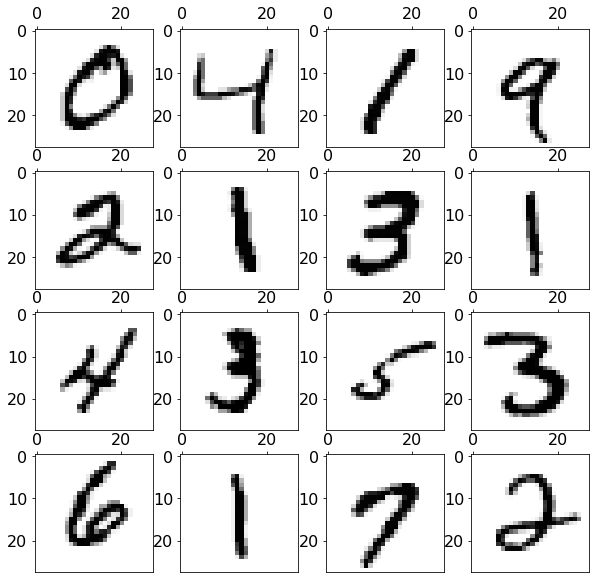

In [4]:
fig = pyplot.figure(figsize=(10,10))

for i in range(1,17):
    pixels = train_set[0][i]
    pixels = np.array(pixels)
    image = pixels.reshape((28, 28))
    ax = fig.add_subplot(4,4,i)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
pyplot.show()

### Part A

Using the softmax formulation, write a Theano expression graph that:
* Calculates the probability of a target element belonging to class $i$ (i.e., the probability that a given image represents a digit between 0 and 9).
* Maximizes it over all classes, and computes the cost function using an L2 regularization approach
* Minimizes the resulting cost function using mini-batch gradient descent. How long does it take for your code to train with 50,000 training examples of the dataset?

*Hint: Use a batch size of 256 examples, a learning rate $\eta = 0.1$, and a regularization factor $\lambda=0.01$*.


### Mini batch gradient descent

In [5]:
def train_logistic_network(lmd, n_epochs=10, batch_size=256, save_freq=100, eta=0.1):
    """ 
    Function to train a logisitic regression classifier with mini batch gradient descent
    Inputs:
        lmd: regularisation parameter for loss function (L2)
        n_epochs: number of epochs
        batch_size: size of batches for mini batch gradient descent
        eta: learning rate for gradient descent updates of the parameters
        save_freq: frequency at which to evaluate the loss on the validation set
    outputs:
        error_train: history of errors on the training set
        error_valid: history of errors on the validation set
        t: time for one epoch
        predict: predict function from trained model
    """
    # Declare Theano symbolic variables for the features and the classes
    x = T.dmatrix("x")
    y = T.lvector("y")

    ########################
    # INPUT LAYER VARIABLES 
    ########################
    
    # input weight vector randomly initialised: 784 features (pixels) per image and 10 possible classes 
    w = theano.shared(np.random.randn(784, 10),
                    name='w',borrow=True)

    # bias term
    b = theano.shared(value=numpy.zeros((10,),dtype=theano.config.floatX),
                name='b',borrow=True)

    ###############
    # THEANO GRAPH
    ###############
    
    # Probability that target belongs to class i
    p_y_given_x = T.nnet.softmax(T.dot(x, w) + b)  
    
    # The prediction of the model (class whose probability is maximal)
    prediction = T.argmax(p_y_given_x, axis=1)      
  
    ################
    # LOSS AND COST 
    ################
    
    # Loss function - negative log likelihood 
    loss = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y]) 
    
    # The cost to minimize - sum of loss and regularisation of parameter weights
    cost = loss.mean() + lmd * (w ** 2).sum()      
    
    ############
    # GRADIENTS
    ############
    
    # Compute the gradient of the cost wrt parameters                     
    gw = T.grad(cost=cost, wrt=w)
    gb = T.grad(cost=cost, wrt=b)                
    
    #############################################
    # TRAINING, TESTING AND VALIDATION FUNCTIONS
    #############################################
    
    train = theano.function(
              inputs=[x,y],
              outputs=[prediction, loss],
              updates=((w, w - eta * gw), (b, b - eta * gb)),name='train')
    validate = theano.function(
              inputs=[x,y],
              outputs=[prediction, loss],name='validate')
    test = theano.function(
              inputs=[x,y],
              outputs=[prediction, loss],name='test')
    predict = theano.function(inputs=[x], outputs=prediction, name='predict')

    
    ##############################
    # MINI BATCH GRADIENT DESCENT 
    ##############################
    
    n_train_batches = shape(train_set[0])[0] // batch_size
    n_valid_batches = shape(valid_set[0])[0] // batch_size
    n_test_batches = shape(test_set[0])[0] // batch_size

    # Place holders for errors
    error_train = []   
    error_valid = []

    start = time.time()
    for i in range(n_epochs):

        for index in range(n_train_batches):

            # Now for the update we only use one mini-batch at a time
            pred, err = train(train_set[0][index * batch_size: (index + 1) * batch_size], \
                              train_set[1][index * batch_size: (index + 1) * batch_size])
            error_train.append(err)  # save the train error for this batch

            errores = []             
            # Now we check the performance on the validation set, every 2 batches.
            if ((i*n_train_batches+index)%save_freq == 0):
                for j in range(n_valid_batches):
                    pred_val, err_val = validate(valid_set[0][j * batch_size: (j + 1) * batch_size], \
                                  valid_set[1][j * batch_size: (j + 1) * batch_size])
                    errores.append(err_val)
                # We get the validation error as the average over batches
                this_error = np.mean(errores)
                error_valid.append(this_error)
    end = time.time()
    t = end - start
    return error_train, error_valid, t, predict

In [10]:
batch_size = 256  # Size of minibatch
n_epochs = 50
error_train, error_valid, t, predict = train_logistic_network(0.001, n_epochs, batch_size)
print('time for one epoch ', (t)/n_epochs)

time for one epoch  0.30317307949066163


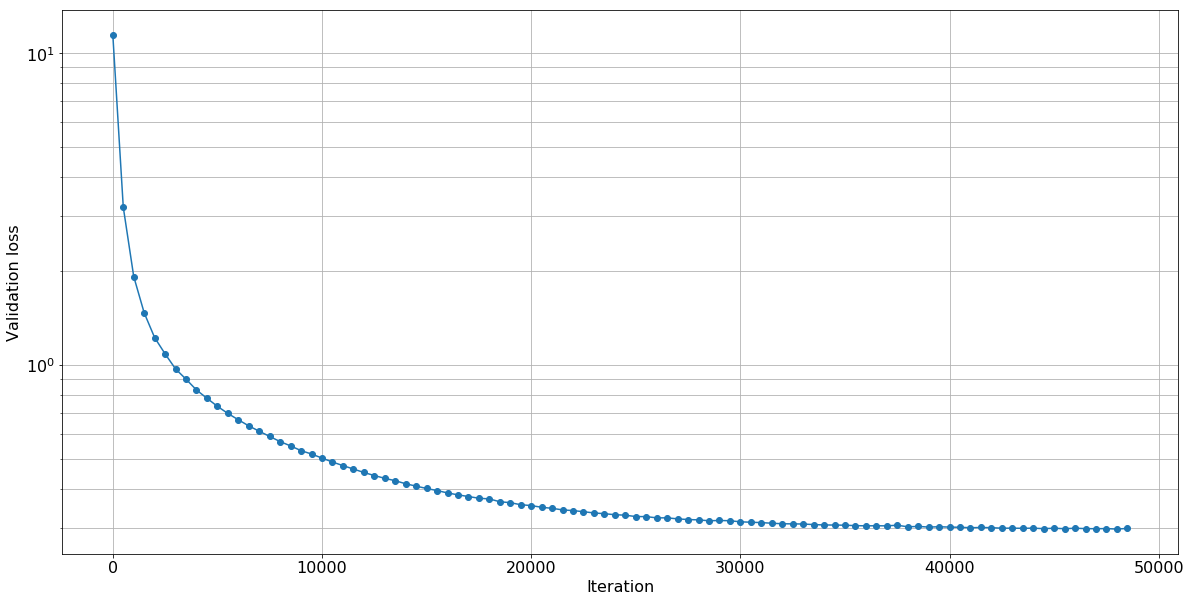

In [11]:
plt.figure(figsize=(20,10))
plt.plot(500*arange(len(error_valid)),np.array(error_valid),marker='o')
plt.yscale('log')
plt.axis('tight')
plt.grid(True, which='both')
plt.xlabel('Iteration')
plt.ylabel('Validation loss')

With initialisation parameters $\lambda - 0.001$, batch size of 256, and 50 epochs, the validation loss is reduced to a final value of 0.29652659928759123 after 4,000,000 iterations (iterations x save frequency = 40,000 * 100). 

### Part B

* Evaluate the validation loss function periodically as you train the classifier and plot it as a function of the epoch. Plot this loss function for several values of the regularization factor.
* When should you stop the training for different values of $\lambda$? Give an approximate answer supported by using the plots.
* Select what you consider the best regularization factor and predict the classes of the test set. Compare with the given labels. What is the test error that you obtain?


In [6]:
## predict on the test set and calculate test error
aa = T.dvector('aa')
bb = T.dvector('bb')
cc = T.mean(T.neq(aa, bb))
f_err = function([aa, bb], cc)

Lambda 0.001
Time for one epoch 0.3129401588439941
Test error = 8.27 %
num correct = 9173
num incorrect = 827

Lambda 0.01
Time for one epoch 0.28892221927642825
Test error = 10.26 %
num correct = 8974
num incorrect = 1026

Lambda 0.1
Time for one epoch 0.316543436050415
Test error = 14.78 %
num correct = 8522
num incorrect = 1478

Lambda 1
Time for one epoch 0.28700737953186034
Test error = 29.69 %
num correct = 7031
num incorrect = 2969



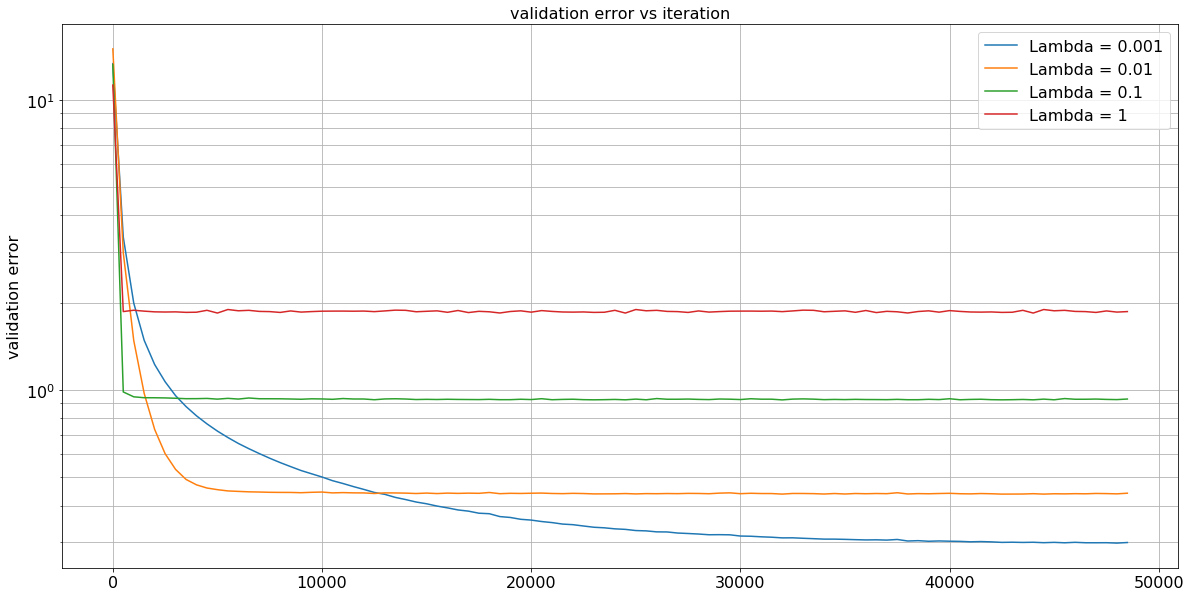

In [13]:
# inital params
batch_size = 256  
n_epochs = 50

plt.figure(figsize=(20,10))

for lmd in [0.001, 0.01, 0.1, 1]:
    error_train, error_valid, t, predict = train_logistic_network(lmd, n_epochs, batch_size)
    
    preds = predict(test_set[0])
    
    print('Lambda {}'.format(lmd))
    print('Time for one epoch {}'.format((t)/n_epochs))
    print('Test error = {} %'.format(100.*f_err(test_set[1], preds)))
    print('num correct = {}\nnum incorrect = {}\n'.format(sum(preds == test_set[1]), sum(preds != test_set[1])))
    plt.plot(500*arange(len(error_valid)),np.array(error_valid), label='Lambda = {}'.format(lmd))
    
plt.legend(loc='best')
plt.title('validation error vs iteration')
plt.ylabel('validation error')
plt.yscale('log')
plt.axis('tight')
plt.grid(True, which='both')

The time for training the network once across all 50,000 samples (one epoch) is approximately similar across different values of regularisation. 

For small values of the regularisation parameter, the validation error decreases slowly but reaches a lower value compared to large values of regularisation, where the validation error decreases rapidly but plateaus at a higher error and does not decrease any further.  

Comparing the test error obtained with the different regularisation parameters, smaller amounts of regularisation ($\lambda = 0.001$) result in lower test error. 

With higher values of lambda, the magnitude of the weights in the softmax regression are squashed and there is high bias so higher final error. With lower values of lambda, the weights are not dampened to such an extent and the model can overfit to the data. This results in lower bias and lower final test error. 

### When should you stop the training for different values of  $\lambda$ 

For smaller values of $\lambda$, a larger number of iterations is required in order to train the network as the validation error decreases more slowly. For example with $\lambda = 0.001$, at least 40000 iterations are required to reach the minimum validation error. WIth large values of $\lambda$, for example $\lambda = 1$, only approx 100 iterations are required for the error to decrease to its minimum value. 

## Problem 2. The Multilayer Perceptron (with one hidden layer)
The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is usually chosen to be either the logistic function or the $\tanh$ function, and its purpose is to project the data into a space where it becomes linealry separable The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. In matrix notation:

$$G(b^{(2)}+W^{(2)}(s(b^{(1)}W^{(1)}x)))$$

with bias vectors $b^{(1)}$, $b^{(2)}$; weight matrices $W^{(1)}$, $W^{(2)}$ and activation functions $G$ and $s$. Here is a diagram:

<td><img src="http://deeplearning.net/tutorial/_images/mlp.png", width=300, height=300></td>

### Part A

Using a similar architecture as in the first part and the same MNIST dataset, built a Theano graph for the multilayer perceptron, using the $\tanh$ function as the non-linearity. Use $\eta = 0.1$ and $\lambda = 0.001$. Experiment with the batch size (use 20, 50, and 100 examples) and the number of units in your hidden layer (use 50, 100, and 200 units). For what combination of these parameters do you obtain the smallest value of the validation loss function after 50 epochs?

In [15]:
def train_MLP(lmd=0.01, n_epochs=10, batch_size=256, n_in =28 * 28, n_hidden=50, n_out=10, eta=0.1, save_freq=1000):
    """ 
    Function to train a Multi layer perceptron with one hidden layer 
    Inputs:
        lmd: regularisation parameter for loss function (L2)
        n_epochs: number of epochs
        batch_size: size of batches for mini batch gradient descent
        n_in: number of units in input layer
        n_hidden: number of units in the hidden layer
        n_out: number of units in output layer
        eta: learning rate for gradient descent updates of the parameters
        save_freq: frequency at which to evaluate the loss on the validation set
    outputs:
        error_train: history of errors on the training set
        error_valid: history of errors on the validation set
        t: time for one epoch
        predict: predict function from trained model
    """
    
    # Declare Theano symbolic variables for the features and the classes
    x = T.dmatrix("x")
    y = T.lvector("y")
    
    ###########################
    # INPUT LAYER VARIABLES 
    ###########################
    
    # input weight vector randomly initialised: 784 features (pixels) per image and 10 possible classes 
    w = theano.shared(np.random.randn(n_hidden, n_out),
                    name='w',borrow=True)

    # bias term
    b = theano.shared(value=numpy.zeros((10,),dtype=theano.config.floatX),
                name='b',borrow=True)
    
    ###########################
    # HIDDEN LAYER VARIABLES 
    ###########################
    
    # sample from a uniform distribution range from -sqrt(6/(n_in+on_ut)) to + sqrt(6/(n_in+on_ut)) 
    # for weights to be initialised in a suitable range for the tanh activation function 
    
    # weights
    rng = numpy.random.RandomState(1234)
    hidden_weight_vals = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_hidden)),
                    high=numpy.sqrt(6. / (n_in + n_hidden)),
                    size=(n_in, n_hidden)
                    ),
                dtype=theano.config.floatX
                )
    w_hidden = theano.shared(value=hidden_weight_vals, name='w_hidden', borrow=True)
    
    # bias
    b_hidden = theano.shared(value=numpy.zeros((n_hidden,),dtype=theano.config.floatX),
                name='b',borrow=True)
    
    ###########################
    # CONNECT LAYERS  input -> hidden layer -> logisitc regression -> output 
    ###########################
    
    # hidden layer output (tanh activation function)
    hidden_layer_linear_output = T.dot(x, w_hidden) + b_hidden
    hidden_layer_output = T.tanh(hidden_layer_linear_output)
    
    # output probability of logisitc regression layer - Probability that target belongs to class i
    p_y_given_x = T.nnet.softmax(T.dot(hidden_layer_output, w) + b)   
    
    ################
    # LOSS AND COST 
    ################
    
    # Loss function - negative log likelihood of output
    loss = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])

    # Cost function: Loss + regularisation on weights across both layers
    cost = loss.mean() + lmd*((w_hidden ** 2).sum() + (w ** 2).sum()) 
    
    ##################################
    # GRADIENTS AND PARAMETER UPDATES
    ##################################
    
    # gather params from both layers
    all_params = [w_hidden, b_hidden, w, b]
    
    # gradient with respect to each parameter
    gparams = [T.grad(cost, param) for param in all_params]
    
    # The prediction of the model (class whose probability is maximal)
    prediction = T.argmax(p_y_given_x, axis=1)

    # update parameters using gradients of cost wrt each param
    updates = [
        (param, param - eta * gparam)
        for param, gparam in zip(all_params, gparams)
    ]
    
    #############################################
    # TRAINING, TESTING AND VALIDATION FUNCTIONS
    #############################################
    
    train = theano.function(
              inputs=[x,y],
              outputs=[prediction, loss],
              updates=updates,
              name='train')
    
    validate = theano.function(
              inputs=[x,y],
              outputs=[prediction, loss],name='validate')
    test = theano.function(
              inputs=[x,y],
              outputs=[prediction, loss],name='test')
    predict = theano.function(inputs=[x], outputs=prediction, name='predict')

    
    ##############################
    # MINI BATCH GRADIENT DESCENT
    ##############################
     
    # split data into batches
    n_train_batches = shape(train_set[0])[0] // batch_size
    n_valid_batches = shape(valid_set[0])[0] // batch_size
    n_test_batches = shape(test_set[0])[0] // batch_size

    # Place holders for errors
    error_train = []   
    error_valid = []

    start = time.time()
    for i in range(n_epochs):

        for index in range(n_train_batches):

            # Now for the update we only use one mini-batch at a time
            pred, err = train(train_set[0][index * batch_size: (index + 1) * batch_size], \
                              train_set[1][index * batch_size: (index + 1) * batch_size])
            error_train.append(err)  # save the train error for this batch

            errores = []             
            
            # Check the performance on the validation set based on the save freq
            if ((i*n_train_batches+index)%save_freq == 0):
                for j in range(n_valid_batches):
                    pred_val, err_val = validate(valid_set[0][j * batch_size: (j + 1) * batch_size], \
                                  valid_set[1][j * batch_size: (j + 1) * batch_size])
                    errores.append(err_val)
                    
                # We get the validation error as the average over batches
                this_error = np.mean(errores)
                error_valid.append(this_error)
                
    end = time.time()
    t = end - start
    return error_train, error_valid, t, predict

## Experiment with batch size [20, 50, 100] and hidden layer units [50,100,200]

Use $\eta = 0.1$ and $\lambda = 0.001$. Experiment with the batch size (use 20, 50, and 100 examples) and the number of units in your hidden layer (use 50, 100, and 200 units). For what combination of these parameters do you obtain the smallest value of the validation loss function after 50 epochs?


### Part B

Stop the trainning at a convenient validation loss and use the trained classifier to predict for the test set. How much better is your test error as compared to the logistic regression classifier?

*Hint 1:* The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, it is advisable to initialize with the interval $[-\sqrt{\frac{6}{fan_{in}+fan_{out}}},\sqrt{\frac{6}{fan_{in}+fan_{out}}}]$, where $fan_{in}$ is the number of units in the $(i-1)$-th layer, and $fan_{out}$ is the number of units in the i-th layer.

*Hint 2:* You should feel free to get inspiration from [these tutorials](http://deeplearning.net/tutorial/mlp.html). However, we expect you to write your own code, inspired by the architecture shown in the lab.

time for one epoch 1.0767415809631347

batch size: 20
units in hidden layer: 50
final validation loss: 0.14242385321746406
Test error = 3.7900000000000005 %
correct predictions: 9621
incorrect predictions: 379

time for one epoch 1.595320520401001

batch size: 20
units in hidden layer: 100
final validation loss: 0.1355142215734147
Test error = 3.66 %
correct predictions: 9634
incorrect predictions: 366

time for one epoch 2.8522902441024782

batch size: 20
units in hidden layer: 200
final validation loss: 0.13631779363910904
Test error = 3.61 %
correct predictions: 9639
incorrect predictions: 361

time for one epoch 0.6142912578582763

batch size: 50
units in hidden layer: 50
final validation loss: 0.1335283084453824
Test error = 3.55 %
correct predictions: 9645
incorrect predictions: 355

time for one epoch 1.0008483982086183

batch size: 50
units in hidden layer: 100
final validation loss: 0.12337615663153877
Test error = 3.26 %
correct predictions: 9674
incorrect predictions: 326

t

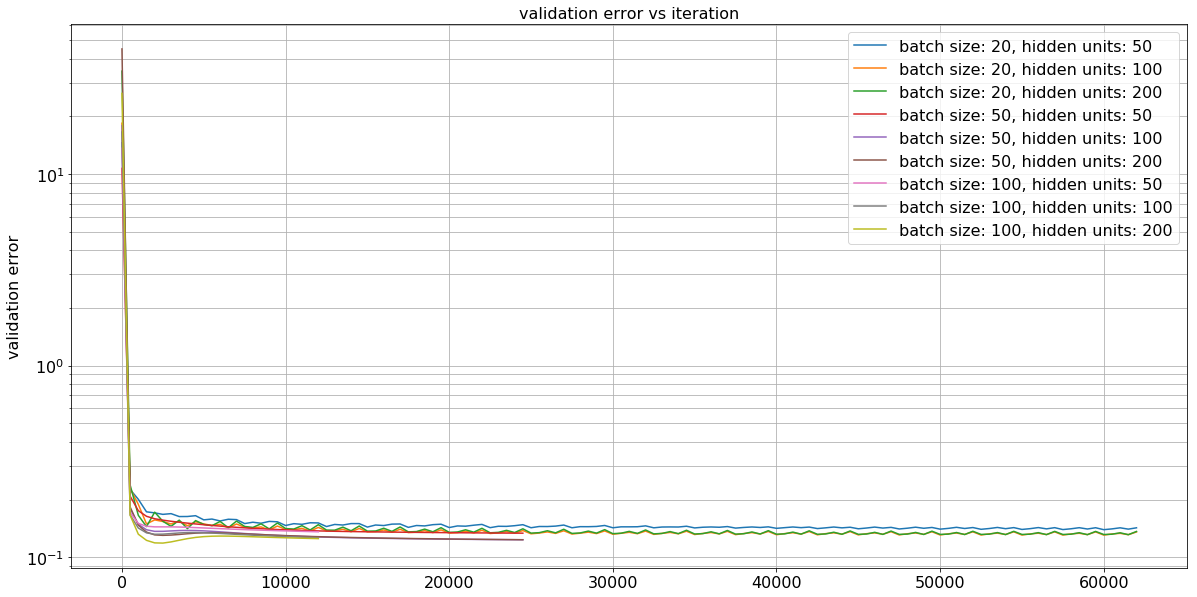

In [17]:
plt.figure(figsize=(20,10))
for batch in [20, 50, 100]:
    for hidden_units in [50, 100, 200]:
        error_train, error_valid, t, predict = train_MLP(lmd=0.001, 
                                                         n_epochs=50, 
                                                         batch_size=batch, 
                                                         n_in =28 * 28, 
                                                         n_hidden=hidden_units, 
                                                         n_out=10,
                                                         eta=0.1)
        plt.plot(500*arange(len(error_valid)),np.array(error_valid), label='batch size: {}, hidden units: {}'.format(batch, hidden_units))
        predict_test = predict(test_set[0])
        print('time for one epoch {}\n'.format((t)/50))
        print('batch size: {}\nunits in hidden layer: {}\nfinal validation loss: {}\nTest error = {} %\ncorrect predictions: {}\nincorrect predictions: {}\n'.format(
             batch, hidden_units, error_valid[-1], 100.*f_err(test_set[1], predict_test), sum(predict_test == test_set[1]), sum(predict_test != test_set[1])))
plt.title('validation error vs iteration')
plt.ylabel('validation error')
plt.yscale('log')
plt.axis('tight')
plt.legend(loc='best')
plt.grid(True, which='both')

In [60]:
predict_test = predict(test_set[0])
correct = sum(predict_test == test_set[1])
incorrect = sum(predict_test != test_set[1])
print('correct ', correct)
print('incorrect ', incorrect)

correct  9628
incorrect  372


In [5]:
print('percent reduction in error rate ',((8.27-3.25)/8.27)*100, '%')

percent reduction in error rate  60.70133010882708 %


The lowest test error of 3.25% from MLP is obtained with $\lambda = 0.001$, 50 epochs, batch size of 100
and 100 hidden layer units. 

The best test error from the logistic regression classifier with $\lambda = 0.001$ and 50 epochs was 8.27%. 

This is a 60% decrease in the test error due to the addition of one hidden layer. 

Even with only 50 units in the hidden layer and batch size of 100, the test error is reduced by more than 50% compared to logistic regression (3.92%). 

Increasing the number of units in the hidden layer reduces the test error as expected but only by a small amount. 